<a href="https://colab.research.google.com/github/muscak/Master-Machine-Learning-Algorithms/blob/master/Nonlinear-Algorithms/Learning-Vector-Quantization/Learning_Vector_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Vector Quantization (LVQ)

In computer science, learning vector quantization (LVQ) is a prototype-based supervised classification algorithm [1]. It is is a lot like k-Nearest Neighbors [2].

## Table of Contents
1. [Introduction](#intro)
2. [Import Libraries](#libraries)
3. [Create Sample Dataset](#sample)
4. [Manual Implementation](#manual)
5. [Conclusion](#conclusion)
6. [References](#references)

## 1. Introduction<a id='intro'></a>

In this study we'll implement Learning Vector Quantization supervised classification algorithm using a sample dataset. 

## 2. Import Libraries<a id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
from sklearn.metrics import accuracy_score

## 3. Create Sample Dataset<a id='sample'></a>

The dataset contains two input variables (x1 and x2) and the class output variable with the values 0 and 1. The dataset contains 10 records, 5 that belong to each class.

In [2]:
x1 = [3.393533211, 3.110073483, 1.343808831, 3.582294042, 2.280362439, 
      7.423436942, 5.745051997, 9.172168622, 7.792783481, 7.939820817]
x2 = [2.331273381, 1.781539638, 3.368360954, 4.67917911, 2.866990263, 
      4.696522875, 3.533989803, 2.511101045, 3.424088941, 0.791637231]
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

df = pd.DataFrame(zip(x1, x2, y), columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,3.393533,2.331273,0
1,3.110073,1.781540,0
2,1.343809,3.368361,0
3,3.582294,4.679179,0
4,2.280362,2.866990,0
5,7.423437,4.696523,1
6,5.745052,3.533990,1
7,9.172169,2.511101,1
8,7.792783,3.424089,1
9,7.939821,0.791637,1


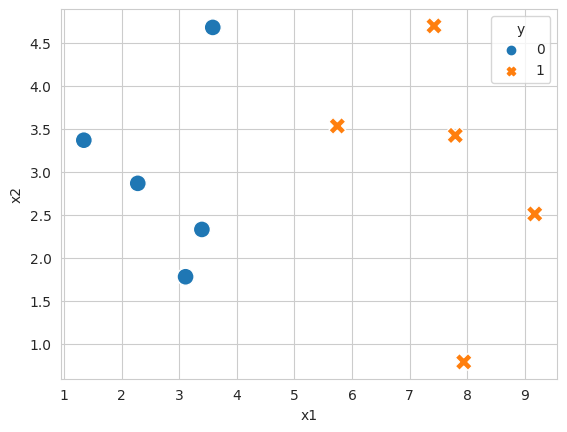

In [3]:
sb.scatterplot(data=df, x='x1', y='x2', hue='y', style='y', s=150)
plt.show()

## 4. Manual Impelementation<a id='manual'></a>

Predictions are made by finding the best match among a library of patterns. The difference is that the library of patterns is learned from training data, rather than using the training patterns themselves (training data). The library of patterns are called codebook vectors and each pattern is called a codebook [2]. 

1. Select codebook vectors which is a list of numbers that have the same input and output attributes as your training data. The model representation is a fixed pool of codebook vectors, learned from the training data. 
2. Calculate the distance from the training data to each codebook vector.
$$Euclidean Distance (a,b) = \sqrt{\sum_{i=1}^{n}(a_i - b_i)^2}$$
3. Select the most similar codebook vector, called the Best Matching Unit (BMU).
4. Update the best matching unit to be closer to the training pattern if it has the same class, $bmu_j = bmu_j + alpha × (training_j − bmu_j)$
otherwise further away $bmu_j = bmu_j - alpha × (training_j − bmu_j)$.

In this sample, we'll pass through the entire training dataset only once (1 epoch) that's why we won't update the learning rate.

In [4]:
# Creates temporary dataframes with BMU calculations for each codebook vector
def create_temp_df(learning_rate, df_index, codebook_vector):
  df_temp = pd.DataFrame(columns=['x1', 'x2', 'y', 'input_x1', 'input_x2', 'input_y', 'Distance', 'Is_BMU', 'new_x1', 'new_x2'])
  df_temp['x1'] = codebook_vector['x1']
  df_temp['x2'] = codebook_vector['x2']
  df_temp['y'] = codebook_vector['y']

  for i in range(0, len(codebook_vector)):
    df_temp['input_x1'] = df.loc[df_index, 'x1']
    df_temp['input_x2'] = df.loc[df_index, 'x2']
    df_temp['input_y'] = df.loc[df_index, 'y']

  # Calculate the distance from the codebook vector
  df_temp['Distance'] = np.sqrt(np.square(df_temp['x1'] - df_temp['input_x1']) 
    + np.square(df_temp['x2'] - df_temp['input_x2']))

  # Calculating Best Matching Unit (BMU)
  min = df_temp['Distance'].min()
  df_temp.loc[df_temp['Distance'] == min, 'Is_BMU'] = 'BMU'
  df_temp.loc[df_temp['Distance'] != min, 'Is_BMU'] = 'NO'

  for i in range(0, len(codebook_vector)):
    if(df_temp.loc[i, 'Is_BMU'] == 'BMU'):
      # Update the BMU to be closer to the training data if it has the same class
      if(df_temp.loc[i, 'y'] == df_temp.loc[i, 'input_y']):
        df_temp.loc[i, 'new_x1'] = df_temp.loc[i, 'x1'] + learning_rate*(df_temp.loc[i, 'input_x1'] - df_temp.loc[i, 'x1'])
        df_temp.loc[i, 'new_x2'] = df_temp.loc[i, 'x2'] + learning_rate*(df_temp.loc[i, 'input_x2'] - df_temp.loc[i, 'x2'])
      # otherwise further away
      else:
        df_temp.loc[i, 'new_x1'] = df_temp.loc[i, 'x1'] - learning_rate*(df_temp.loc[i, 'input_x1'] - df_temp.loc[i, 'x1'])
        df_temp.loc[i, 'new_x2'] = df_temp.loc[i, 'x2'] - learning_rate*(df_temp.loc[i, 'input_x2'] - df_temp.loc[i, 'x2'])
    else:
      df_temp.loc[i, 'new_x1'] = df_temp.loc[i, 'x1']
      df_temp.loc[i, 'new_x2'] = df_temp.loc[i, 'x2']

  return df_temp

In [5]:
# Train the model using the codebook_vector
def train(learning_rate, iter):
  df_training = pd.DataFrame(columns=['x1', 'x2', 'y', 'input_x1', 'input_x2', 'input_y', 'Distance', 'Is_BMU', 'new_x1', 'new_x2'])
  # Use the initial codebook vector
  df_temp = create_temp_df(learning_rate, 0, df_codebook_vector)
  df_training = pd.concat([df_training, df_temp], ignore_index=True)

  for i in range(1, iter):
    new_codebook_vector = df_temp[['new_x1', 'new_x2', 'y']]
    new_codebook_vector.rename(columns={'new_x1': 'x1', 'new_x2': 'x2'}, inplace=True)
    new_codebook_vector['x1'] = pd.to_numeric(new_codebook_vector['x1'], errors='coerce')
    new_codebook_vector['x2'] = pd.to_numeric(new_codebook_vector['x2'], errors='coerce')

    df_temp = create_temp_df(learning_rate, i, new_codebook_vector)
    df_training = pd.concat([df_training, df_temp], ignore_index=True)
  
  return df_training

In [6]:
# Creating codebook vector by randomly selecting samples from dataset 
# This can be randomly generated data with the same scale as the training data.
nr_codebook_vector = 4
df_codebook_vector = df.sample(n = nr_codebook_vector).reset_index(drop=True)
df_codebook_vector

##############################################################################
#### Below data points are from the book and can be used to check
#### if the functions return the correct values
# x1 = [3.582294042, 7.792783481, 7.939820817, 3.393533211]
# x2 = [0.791637231, 2.331273381, 2.866990263, 4.67917911]
# y = [0, 0, 1, 1]
# df_codebook_vector = pd.DataFrame(zip(x1, x2, y), columns=['x1', 'x2', 'y'])
##############################################################################

,x1,x2,y
0,3.393533,2.331273,0
1,9.172169,2.511101,1
2,7.423437,4.696523,1
3,7.939821,0.791637,1


In [7]:
nr_iter = 10
df_training = train(0.7, nr_iter)

# Create a new codebook_vector and assign the last items from the trainined data
df_trained_codebook_vector = pd.DataFrame(columns=['x1', 'x2', 'y'])
df_trained_codebook_vector['x1'] = df_training.loc[len(df_training)-nr_codebook_vector:len(df_training),'x1']
df_trained_codebook_vector['x2'] = df_training.loc[len(df_training)-nr_codebook_vector:len(df_training),'x2']
df_trained_codebook_vector['y'] = df_training.loc[len(df_training)-nr_codebook_vector:len(df_training),'y']
df_trained_codebook_vector

,x1,x2,y
36,2.519463,3.254282,0
37,9.172169,2.511101,1
38,7.329519,3.561687,1
39,7.939821,0.791637,1


⚠️ **Important**

In our example we'll pass through the entire training dataset only once (1 epoch) we won't update (decrease) the `learning_rate` parameter. If we would, then we should update it as per below;

$$Learning Rate = α × (1 - \frac{Epoch}{Max Epoch})$$
Where LearningRate is the learning rate for the current $epoch$ , $α$
is the learning rate specified of the training, $MaxEpoch$ is the total number of epochs to run the algorithm.

In [8]:
# Predict the labels using trained codebook_vector
def predict():
  df_predict = pd.DataFrame(columns=['x1', 'x2', 'y', 'input_x1', 
                                     'input_x2', 'input_y', 'Distance', 
                                     'Is_BMU', 'Prediction'])

  for i in range(0, nr_iter):
    df_temp = pd.DataFrame(columns=['x1', 'x2', 'y', 'input_x1', 
                                    'input_x2', 'input_y', 'Distance', 
                                    'Is_BMU', 'Prediction'])
    df_temp['x1'] = df_trained_codebook_vector['x1']
    df_temp['x2'] = df_trained_codebook_vector['x2']
    df_temp['y'] = df_trained_codebook_vector['y']

    df_temp['input_x1'] = df.loc[i, 'x1']
    df_temp['input_x2'] = df.loc[i, 'x2']
    df_temp['input_y'] = df.loc[i, 'y']

    # Calculate the distances from the new codebook vector
    df_temp['Distance'] = np.sqrt(np.square(df_temp['x1'] - df_temp['input_x1']) 
    + np.square(df_temp['x2'] - df_temp['input_x2']))

    # Calculate BMUs based on the new distances
    for j in range(0, len(df_temp)):
      min = df_temp['Distance'].min()
      df_temp.loc[df_temp['Distance'] == min, 'Is_BMU'] = 'BMU'
      df_temp.loc[df_temp['Distance'] != min, 'Is_BMU'] = 'NO'

    df_predict = pd.concat([df_predict, df_temp], ignore_index=True)

    # If the data is BMU, then it can
    df_predict.loc[df_predict['Is_BMU'] == 'BMU', 'Prediction'] = df_predict['y']

    df_predict.dropna(subset=['Prediction'], inplace=True)
    df_predict['input_y'] = pd.to_numeric(df_predict['input_y'], errors='coerce')
    df_predict['Prediction'] = pd.to_numeric(df_predict['Prediction'], errors='coerce')

  return df_predict

In [9]:
df_predict = predict()
df_predict

,x1,x2,y,input_x1,input_x2,input_y,Distance,Is_BMU,Prediction
0,2.519463,3.254282,0,3.393533,2.331273,0,1.271197,BMU,0
1,2.519463,3.254282,0,3.110073,1.781540,0,1.586755,BMU,0
2,2.519463,3.254282,0,1.343809,3.368361,0,1.181176,BMU,0
3,2.519463,3.254282,0,3.582294,4.679179,0,1.777622,BMU,0
4,2.519463,3.254282,0,2.280362,2.866990,0,0.455153,BMU,0
5,7.329519,3.561687,1,7.423437,4.696523,1,1.138715,BMU,1
6,7.329519,3.561687,1,5.745052,3.533990,1,1.584709,BMU,1
7,9.172169,2.511101,1,9.172169,2.511101,1,0.000000,BMU,1
8,7.329519,3.561687,1,7.792783,3.424089,1,0.483268,BMU,1
12,7.939821,0.791637,1,7.939821,0.791637,1,0.000000,BMU,1


In [10]:
acc = accuracy_score(df_predict['input_y'].values, df_predict['Prediction'].values)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 100.00%


## 5. Conclusion<a id='conclusion'></a>

LVQ uses codebook vectors which are a compression of the training data. The codebook vectors are used to make predictions using the same technique as $k$-Nearest Neighbors and it from the same curse of dimensionality in making predictions as $k$-Nearest Neighbors.

## 6. References<a id='refences'></a>

[1] [Learning Vector Quantization](https://en.wikipedia.org/wiki/Learning_vector_quantization)

[2] [How To Implement Learning Vector Quantization (LVQ) From Scratch With Python](https://machinelearningmastery.com/implement-learning-vector-quantization-scratch-python/)